# Experimentos para os dados textuais

In [1]:
import datetime
import re
import json
import yaml
import sys
import os
import logging
import logging.config
import time
import multiprocessing
from collections import OrderedDict
import requests
import sqlalchemy
import string
import unicodedata
import yaml
import warnings
warnings.filterwarnings('ignore')

########################################
# external libs
########################################
import joblib
from joblib import delayed, Parallel

########################################
# ml
########################################
from lightgbm import LGBMClassifier
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import issparse

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    balanced_accuracy_score,
    average_precision_score,
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    jaccard_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, Binarizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from lightgbm import LGBMClassifier

import xgboost as xgb
from xgboost import XGBClassifier

#################################
# VARIÁVEIS GLOBAIS
#################################
N_JOBS = -1
BASE_DIR = './'
DEFAULT_RANDOM_STATE = 42

#################################
# LOGS
#################################
with open(os.path.join(BASE_DIR, 'log.conf.yaml'), 'r') as f:
    config = yaml.safe_load(f.read())
    logging.config.dictConfig(config)

In [2]:
class TextCleaner(BaseEstimator, TransformerMixin):
    stop_words = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no',
                  'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu',
                  'sua', 'ou', 'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo',
                  'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem',
                  'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu',
                  'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe',
                  'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes',
                  'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas',
                  'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está',
                  'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam',
                  'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos',
                  'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve',
                  'houvemos', 'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse',
                  'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos',
                  'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram',
                  'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos',
                  'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos',
                  'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos',
                  'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem',
                  'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']

    def __init__(self, n_jobs=1):
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        sX = pd.Series(X)

        def tratar_texto(t):

            if not t:
                return ''
            if type(t) != str:
                t = str(t)

            t = t.replace('\\n', ' ')
            t = t.replace('null', ' ')
            t = t.lower()
            regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
            t = regex.sub(" ", t)
            lista = t.split()

            # retira stopwords e sinais de pontuação
            lista = [palavra for palavra in lista if palavra not in self.stop_words and palavra not in string.punctuation]

            # retira os dígitos
            lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
            lista = lista.replace('\n', ' ').replace('\r', ' ')
            lista = lista.replace(' o ', ' ').replace(' a ', ' ').replace(' os ', ' ').replace(' as ', ' ')  # retira o, a, os, as que ainda permaneceiam no texto
            lista = re.sub(r" +", ' ', lista)  # retira espaços em excesso

            nfkd = unicodedata.normalize('NFKD', lista)
            lista = u"".join([c for c in nfkd if not unicodedata.combining(c)])  # retira acento

            return lista

        def tratar_serie(s):
            return s.apply(tratar_texto)

        split = np.array_split(sX, self.n_jobs)
        r = Parallel(n_jobs=self.n_jobs, verbose=0)(delayed(tratar_serie)(s) for s in split)
        return pd.concat(r)
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names, default_value=0):
        self.feature_names = feature_names
        self.default_value = default_value

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # incluir teste para colunas ausentes
        X = X.copy()
        for c in self.feature_names:
            if c not in X.columns:
                X[c] = self.default_value
        return X[self.feature_names]

# Dataset Texto

In [3]:
# # manter no dataset apenas manifestacoes até maio
# sdp = sqlalchemy.create_engine('mssql+pyodbc://xxxxxxxxxxx')
# query = """
# SELECT [IdManifestacao]
# FROM [db_denuncias_origem].[eouv].[Manifestacao]
# WHERE [DatRegistro] < convert(datetime, '01/06/2021', 103)
# ORDER BY [DatRegistro] desc
# """
# df_datas = pd.read_sql(query, sdp)

In [4]:
# # dataset não anonimizado
# # não será disponibilizado com o código 
# # fonte devido a restrições de sigilo institucional
# df = pd.read_parquet('datasets/df_treinamento_faro.parquet')
# df = df[df['IdManifestacao'].isin(df_datas['IdManifestacao'])].copy()
# df['TextoCompleto'] = df['TxtFatoManifestacao'].str.cat(df['TextoAnexo'], sep=' ').astype(str)
# X_txt, y_txt = df[['TextoCompleto']], df['GrauAptidao'].apply(lambda x: 1 if x > 50 else 0)

In [5]:
# %%time
# # preprocessamento do texto (remoção de stopwords, remoção de acentos, remoção de pontuações, remoção de números, transformação de todos os caracteres em lowercase)
# X_txt = TextCleaner(n_jobs=N_JOBS).fit_transform(X_txt['TextoCompleto']).to_frame()

In [6]:
# %%time

# # separação do dataset em treino e teste
# X_txt_train, X_txt_test, y_txt_train, y_txt_test = train_test_split(X_txt, y_txt, test_size=.2, random_state=DEFAULT_RANDOM_STATE, stratify=y_txt) 

# # utiliza o tf-idf para aprender o vocabulário e pesos a partir dos dados de treinamento
# tf_idf = TfidfVectorizer(min_df=5, max_df=.5, max_features=2000)
# tf_idf.fit(X_txt_train['TextoCompleto'])

In [7]:
# transforma os datasets de treinamento
# X_txt_train_idf = tf_idf.transform(X_txt_train['TextoCompleto'])
# X_txt_test_idf = tf_idf.transform(X_txt_test['TextoCompleto'])

In [8]:
# X_txt_train.index
# X_txt_train_idf.todense().shape

In [9]:
# df_tmp = pd.DataFrame(X_txt_train_idf.todense(), 
#                       index=X_txt_train.index,
#                       columns=[f'{i:>04}' for i in range(0, X_txt_train_idf.shape[1])])
# df_tmp['LABEL'] = y_txt_train
# df_tmp.to_parquet('datasets/df_train_txt.parquet')

# df_tmp = pd.DataFrame(X_txt_test_idf.todense(), 
#                       index=X_txt_test.index,
#                       columns=[f'{i:>04}' for i in range(0, X_txt_test_idf.shape[1])])
# df_tmp['LABEL'] = y_txt_test
# df_tmp.to_parquet('datasets/df_test_txt.parquet')

In [10]:
df_train = pd.read_parquet('datasets/df_train_txt.parquet')
X_txt_train_idf, y_txt_train = df_train.drop(columns=['LABEL']), df_train['LABEL']

df_test = pd.read_parquet('datasets/df_test_txt.parquet')
X_txt_test_idf, y_txt_test = df_test.drop(columns=['LABEL']), df_test['LABEL']

In [11]:
%%time

pipeline = Pipeline(steps=[
    ('model', RandomForestClassifier())
])

metrics = ['roc_auc','balanced_accuracy', 'average_precision', 'recall', 'accuracy', 'f1_macro','f1_weighted']

results = [
    
]

model = [
    RandomForestClassifier,
    LogisticRegression,
    XGBClassifier,
    KNeighborsClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    SGDClassifier,
    SVC, 
    NuSVC, 
    LinearSVC,
    BernoulliNB, 
    LGBMClassifier,
    MLPClassifier,
    AdaBoostClassifier,
]

N_ESTIMATORS_ITERATORS = 200
POS_WEIGHT = pd.Series(y_txt_train).value_counts()[0]/pd.Series(y_txt_train).value_counts()[1]
class_weight = {0: 1, 1: POS_WEIGHT}

params = [
    {
        'model__n_estimators': [N_ESTIMATORS_ITERATORS],
        'model__max_depth': [5,7,9],
        'model__min_samples_split': [2,3],
        'model__min_samples_leaf': [1,2],
        'model__class_weight': [class_weight],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__max_samples': [.8, 1],
    },
    {
        'model__penalty' : ['l2'],
        'model__C' : [1],
        'model__solver' : ['liblinear'],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
        'model__learning_rate': [0.01],
        'model__n_estimators': [N_ESTIMATORS_ITERATORS],
        'model__subsample' : [.8,.45],
        'model__min_child_weight': [1],
        'model__max_depth': [3,4,7],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__reg_lambda': [2],
        'model__scale_pos_weight': [POS_WEIGHT]
    },
    {
        'model__n_neighbors' : [5,7,9,11],
    },
    {
        'model__n_estimators': [5],
        'model__max_samples': [.8],
        'model__random_state': [DEFAULT_RANDOM_STATE],
    },
    {
        'model__n_estimators': [N_ESTIMATORS_ITERATORS],
        'model__max_samples' : [.8],
        'model__max_depth': [6,7],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
        'model__gamma': ['auto'],
        'model__C': [0.5],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
        'model__gamma': ['auto'],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
    },
    {
        'model__n_estimators': [N_ESTIMATORS_ITERATORS],
        'model__subsample': [.6,.7,.8,1],
        'model__random_state': [DEFAULT_RANDOM_STATE],
        'model__class_weight': [class_weight],
    },
    {
        'model__alpha': [1], 
        'model__max_iter': [50],
    },
    {
    }
]


logging.info('Início')
for m, p in zip(model, params):
    logging.info('Modelo: {}'.format(m.__name__))
    
    p['model'] = [m()]
    
    rskfcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=DEFAULT_RANDOM_STATE)
    cv = GridSearchCV(estimator=pipeline,param_grid=p, cv=rskfcv, n_jobs=N_JOBS, error_score=0, refit=True, scoring='roc_auc', verbose=1)
    cv.fit(X_txt_train_idf, y_txt_train)
    model = cv.best_estimator_
    best_params = cv.best_params_
    
    valores = cross_validate(m(**{k[7:]: v for k,v in best_params.items() if k.startswith('model__')}), X_txt_train_idf, y_txt_train, scoring=metrics, cv=rskfcv, verbose=1)
    cv_scores = {k[5:]: np.mean(v) for k, v in valores.items() if k not in ['fit_time', 'score_time']}

    linha = {
        'Modelo': m.__name__,
        'ScoreTreino': cv.score(X_txt_train_idf, y_txt_train),
        'BestParams': best_params,
        'RawScores': {k[5:]: v for k, v in valores.items() if k not in ['fit_time', 'score_time']}
    }
    linha.update(cv_scores)
    results.append(linha)

logging.info('Fim')

[2021-10-13 19:04:33,297][<timed exec>:<module>:110 INFO] Início
[2021-10-13 19:04:33,302][<timed exec>:<module>:112 INFO] Modelo: RandomForestClassifier
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   40.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-10-13 19:05:29,575][<timed exec>:<module>:112 INFO] Modelo: LogisticRegression


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-10-13 19:05:32,531][<timed exec>:<module>:112 INFO] Modelo: XGBClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished


[2021-10-13 19:14:30,482][<timed exec>:<module>:112 INFO] Modelo: KNeighborsClassifier
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   34.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min finished


[2021-10-13 19:16:52,077][<timed exec>:<module>:112 INFO] Modelo: BaggingClassifier
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    9.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-10-13 19:18:01,690][<timed exec>:<module>:112 INFO] Modelo: ExtraTreesClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   49.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-10-13 19:18:18,451][<timed exec>:<module>:112 INFO] Modelo: SGDClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-10-13 19:18:27,461][<timed exec>:<module>:112 INFO] Modelo: SVC


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   43.5s remaining:   28.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.2min finished


[2021-10-13 19:24:35,356][<timed exec>:<module>:112 INFO] Modelo: NuSVC
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   46.8s remaining:   31.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.7min finished


[2021-10-13 19:28:48,065][<timed exec>:<module>:112 INFO] Modelo: LinearSVC
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-10-13 19:28:51,235][<timed exec>:<module>:112 INFO] Modelo: BernoulliNB


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-10-13 19:28:54,812][<timed exec>:<module>:112 INFO] Modelo: LGBMClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   46.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-10-13 19:30:10,767][<timed exec>:<module>:112 INFO] Modelo: MLPClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   36.7s remaining:   24.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   52.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2021-10-13 19:33:21,288][<timed exec>:<module>:112 INFO] Modelo: AdaBoostClassifier


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.3s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   34.1s finished


[2021-10-13 19:34:10,140][<timed exec>:<module>:134 INFO] Fim
Wall time: 29min 36s


In [12]:
df_results_txt = pd.DataFrame(results)
df_results_txt = pd.DataFrame(df_results_txt)
df_results_txt = df_results_txt.sort_values('roc_auc', ascending=False)
df_results_txt

,Modelo,ScoreTreino,BestParams,RawScores,roc_auc,balanced_accuracy,average_precision,recall,accuracy,f1_macro,f1_weighted
12,MLPClassifier,0.894099,"{'model': MLPClassifier(alpha=1, max_iter=50),...","{'roc_auc': [0.8013980263157895, 0.82748538011...",0.793876,0.629697,0.625039,0.333988,0.750000,0.640681,0.721269
1,LogisticRegression,0.923601,"{'model': LogisticRegression(C=1, class_weight...","{'roc_auc': [0.7996619152046783, 0.82775950292...",0.792073,0.722680,0.620465,0.697208,0.733025,0.702772,0.741246
0,RandomForestClassifier,0.913656,{'model': RandomForestClassifier(class_weight=...,"{'roc_auc': [0.7711531432748537, 0.79262609649...",0.779384,0.682731,0.593682,0.559837,0.732716,0.681582,0.733388
2,XGBClassifier,0.905125,"{'model': XGBClassifier(base_score=None, boost...","{'roc_auc': [0.768046418128655, 0.800073099415...",0.776782,0.692697,0.595321,0.625408,0.720062,0.681328,0.726365
5,ExtraTreesClassifier,0.910055,{'model': ExtraTreesClassifier(class_weight={0...,"{'roc_auc': [0.7737116228070176, 0.79472770467...",0.774299,0.691214,0.588236,0.623314,0.718827,0.679860,0.725151
7,SVC,0.806066,"{'model': SVC(C=0.5, class_weight={0: 1, 1: 2....","{'roc_auc': [0.7622898391812866, 0.78138706140...",0.773076,0.500000,0.531993,0.900000,0.336728,0.246912,0.179633
11,LGBMClassifier,0.998511,"{'model': LGBMClassifier(class_weight={0: 1, 1...","{'roc_auc': [0.7295778508771928, 0.81387061403...",0.763812,0.680994,0.579903,0.543202,0.737037,0.682372,0.735918
8,NuSVC,0.923391,"{'model': NuSVC(class_weight={0: 1, 1: 2.37148...","{'roc_auc': [0.7903874269005848, 0.79947916666...",0.760336,0.665261,0.586163,0.459966,0.748765,0.675006,0.737913
9,LinearSVC,0.978943,"{'model': LinearSVC(class_weight={0: 1, 1: 2.3...","{'roc_auc': [0.7418220029239766, 0.79376827485...",0.747210,0.686523,0.549122,0.622272,0.712654,0.674135,0.719672
6,SGDClassifier,0.962716,"{'model': SGDClassifier(class_weight={0: 1, 1:...","{'roc_auc': [0.7404970760233918, 0.78732638888...",0.741808,0.686177,0.540099,0.651407,0.700309,0.667499,0.709874


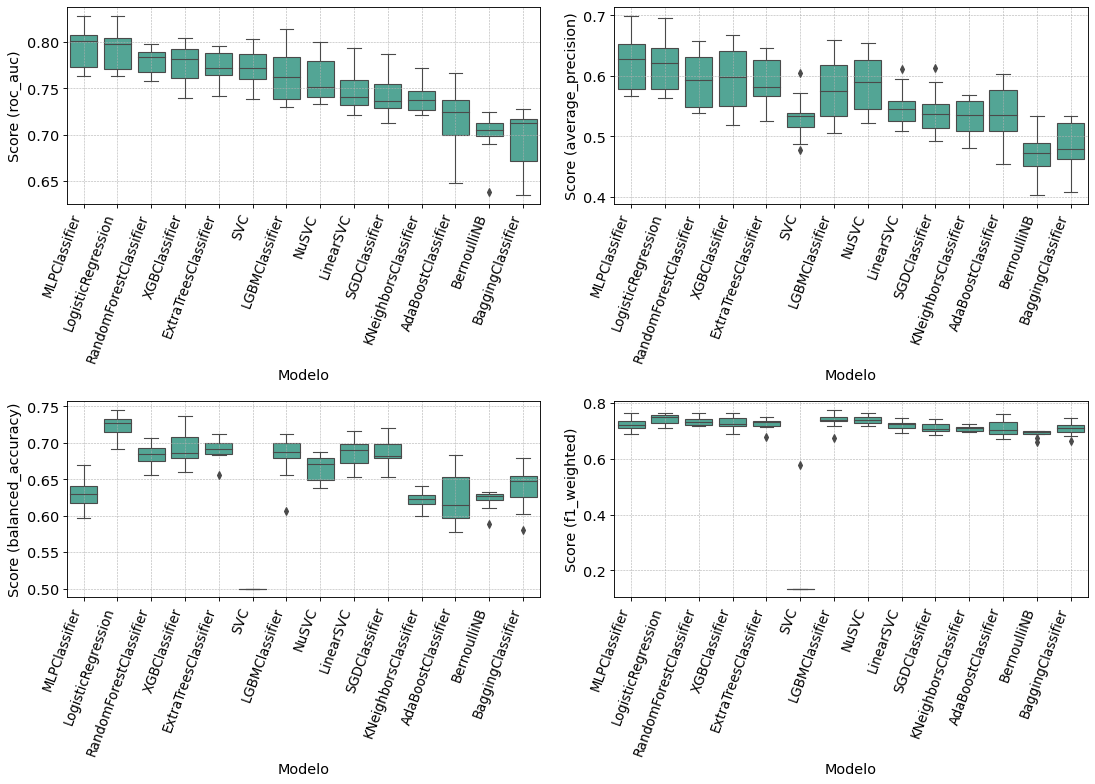

In [13]:
metricas = ['roc_auc', 'average_precision', 'balanced_accuracy', 'f1_weighted']

matplotlib.rcParams.update({'font.size': 13})
fig, axis = plt.subplots(2,2, figsize=(14, 10), dpi=80)

axis = np.ravel(axis)
for i, m in enumerate(metricas):
    df_score = pd.DataFrame({m: s for m, s in zip(df_results_txt['Modelo'], df_results_txt['RawScores'].apply(lambda x: x[m]))})
    df_score = pd.melt(df_score, var_name='Modelo', value_name='Score')
    sns.boxplot(x='Modelo', y='Score', data=df_score, color='#45B39D', linewidth=1, ax=axis[i])
    axis[i].set_xlabel('Modelo')
    axis[i].set_ylabel(f'Score ({m})')
    axis[i].set_xticklabels(labels=df_score['Modelo'].drop_duplicates(), rotation=70, ha='right', fontsize=12)
    axis[i].grid(which='major',linestyle='--', linewidth=0.5, )
    
plt.tight_layout()
# plt.savefig('./docs/tcc/fig_00500_comparacao_score_modelos_texto.png')
plt.show()

# Tunning Hiperparametros

In [14]:
df_results_txt['BestParams'].iloc[0]

{'model': MLPClassifier(alpha=1, max_iter=50),
 'model__alpha': 1,
 'model__max_iter': 50}

In [15]:
from skopt import forest_minimize
from sklearn.model_selection import RepeatedStratifiedKFold



def tune_lgbm(params):
    logging.info(params)
    n_estimators = params[0] 
    max_depth = params[1]
    reg_lambda = params[2]
    learning_rate = params[3]
    subsample = params[4]
    reg_alpha = params[5]
    gamma = params[6]
#     min_df = params[7]
#     max_df = params[8]
#     max_features = params[9]
#     ngram_range = (1, params[10])
    
    scale_pos_weight = y_txt_train.value_counts()[0]/y_txt_train.value_counts()[1]
    
    model = XGBClassifier(base_score=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=gamma,
               importance_type='gain', interaction_constraints=None,
               learning_rate=learning_rate, max_delta_step=None, max_depth=max_depth,
               n_estimators=n_estimators, n_jobs=None, num_parallel_tree=None,
               random_state=DEFAULT_RANDOM_STATE, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
               scale_pos_weight=scale_pos_weight, subsample=subsample, 
               validate_parameters=None, verbosity=None)
    
    rskfcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=DEFAULT_RANDOM_STATE)
    score = cross_val_score(model, X_txt_train_idf, y_txt_train, scoring='roc_auc', cv=rskfcv)
    return -np.mean(score)

space = [
    (100, 1000), # n_estimators
    (1, 20), # max_depth
    (0.01, 5.0), # reg_lambda
    (0.0001, 0.03), # learning_rate
    (0.4, 1.), # subsample
    (0.01, 5.0), # reg_alpha
    (0.01, 5.0), # gamma
#     (2, 5), # min_df
#     (0.5, 1.0), # max_df
#     (100, 5000), # max_features
#     (1, 2), # ngram_range
]
#alterar qdo colocar no HPC
res = forest_minimize(tune_lgbm, space, random_state=DEFAULT_RANDOM_STATE, n_random_starts=20, n_calls=50, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[2021-10-13 19:34:11,676][2834506427.py:tune_lgbm:7 INFO] [535, 15, 3.662649769638912, 0.017999888677491395, 0.49361118426546197, 0.7884126564776514, 0.2998372247193154]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 505.4045
Function value obtained: -0.7831
Current minimum: -0.7831
Iteration No: 2 started. Evaluating function at random point.
[2021-10-13 19:42:37,081][2834506427.py:tune_lgbm:7 INFO] [187, 4, 0.7229054214304846, 0.019561565341170702, 0.4338469474162602, 3.612773873611456, 4.693378017988594]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 61.5816
Function value obtained: -0.7710
Current minimum: -0.7831
Iteration No: 3 started. Evaluating function at random point.
[2021-10-13 19:43:38,663][2834506427.py:tune_lgbm:7 INFO] [485, 1, 1.5281687923680936, 0.015790217305803912, 0.6591670111852694, 1.4632334095882296, 3.063145944664674]
Iteration No: 3 ended. Evaluation done a

In [16]:
res.x

[489,
 19,
 0.09637818751200396,
 0.006850076796621602,
 0.47298329835968017,
 1.6946249738589954,
 3.1228013495601403]

In [17]:
params = [759, 4, 4.038900470867496, 0.022685086880347725, 0.7851344045803921, 0.1308550296924623, 0.022216673300650254, 5, 0.6568820361887584, 4358, 1]
params = [561, 8, 4.224223904903976, 0.02244487129310769, 0.7238152794334479, 2.937888316662603, 4.82662398324805, 5, 0.7713480415791243, 2162, 1]
params = res.x

scale_pos_weight = pd.Series(y_txt_train).value_counts()[0]/pd.Series(y_txt_train).value_counts()[1]
n_estimators = params[0] 
max_depth = params[1]
reg_lambda = params[2]
learning_rate = params[3]
subsample = params[4]
reg_alpha = params[5]
gamma = params[6]
# min_df = params[7]
# max_df = params[8]
# max_features = params[9]
# ngram_range = (1, params[10])

# tfidf = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, ngram_range=ngram_range)
# tfidf.fit(X_txt_train['TextoCompleto'])

# X_txt_train_idf = tfidf.transform(X_txt_train['TextoCompleto'])
# X_txt_test_idf = tfidf.transform(X_txt_test['TextoCompleto'])

scale_pos_weight = y_txt_train.value_counts()[0]/y_txt_train.value_counts()[1]

model = XGBClassifier(base_score=None, colsample_bylevel=None,
           colsample_bynode=None, colsample_bytree=None, gamma=gamma,
           gpu_id=None, importance_type='gain', interaction_constraints=None,
           learning_rate=learning_rate, max_delta_step=None, max_depth=max_depth,
           n_estimators=n_estimators, n_jobs=None, num_parallel_tree=None,
           random_state=DEFAULT_RANDOM_STATE, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
           scale_pos_weight=scale_pos_weight, subsample=subsample, tree_method=None,
           validate_parameters=None, verbosity=None)

model.fit(X_txt_train_idf, y_txt_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=3.1228013495601403,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.006850076796621602, max_delta_step=0,
              max_depth=19, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=489, n_jobs=0,
              num_parallel_tree=1, random_state=42,
              reg_alpha=1.6946249738589954, reg_lambda=0.09637818751200396,
              scale_pos_weight=2.371488033298647, subsample=0.47298329835968017,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
p = model.predict(X_txt_test_idf)

In [19]:
balanced_accuracy_score(y_txt_test, model.predict(X_txt_test_idf) )

0.7382579893717697

In [20]:
print(classification_report(y_txt_test, model.predict(X_txt_test_idf) ))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       570
           1       0.58      0.69      0.63       241

    accuracy                           0.76       811
   macro avg       0.72      0.74      0.72       811
weighted avg       0.77      0.76      0.76       811



In [21]:
print(confusion_matrix(y_txt_test, model.predict(X_txt_test_idf) ))

[[449 121]
 [ 75 166]]


In [22]:
balanced_accuracy_score(y_txt_test, p)

0.7382579893717697

In [23]:
f1_score(y_txt_test, p)

0.6287878787878789

In [24]:
recall_score(y_txt_test, p)

0.6887966804979253

In [25]:
precision_score(y_txt_test, p)

0.578397212543554

In [26]:
accuracy_score(y_txt_test, p)

0.7583230579531443

In [27]:
roc_auc_score(y_txt_test, model.predict_proba(X_txt_test_idf)[:, 1])

0.8212491810438962

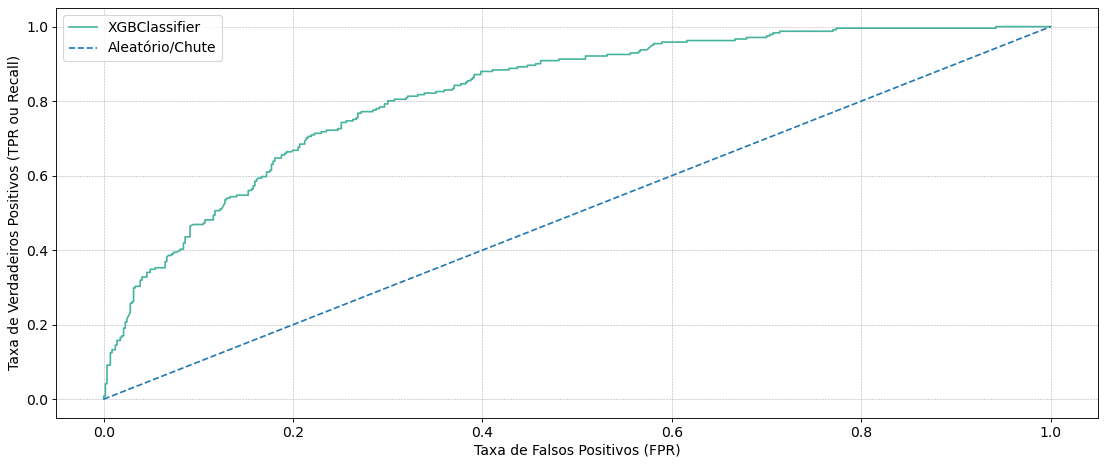

In [28]:
matplotlib.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(14, 6), dpi=80)
# plt.title(' Curva Característica de Operação do Receptor (ROC)')
lr_fpr, lr_tpr, thresholds =  roc_curve(y_txt_test.values, model.predict_proba(X_txt_test_idf)[:,1], drop_intermediate=False, pos_label=1)
plt.plot(lr_fpr, lr_tpr, label='XGBClassifier',color='#45B39D')
plt.plot([0, 1], [0,1], linestyle='--', label='Aleatório/Chute')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR ou Recall)')
plt.legend()
plt.grid(which='major',linestyle='--', linewidth=0.5)
plt.tight_layout()
# plt.savefig('./docs/tcc/fig_00600_roc_auc_texto.png')
plt.show()

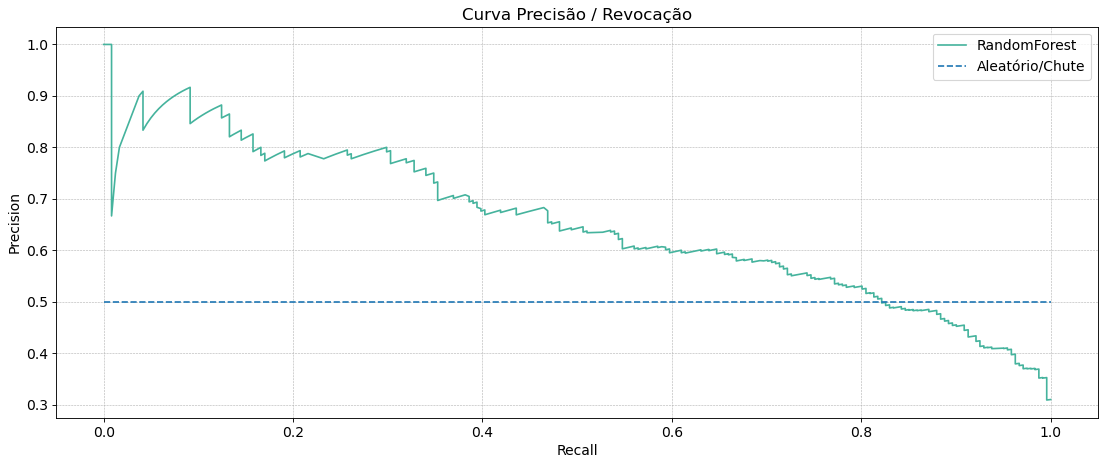

In [29]:
matplotlib.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(14, 6), dpi=80)

plt.title('Curva Precisão / Revocação')
lr_precision, lr_recall, thresholds =  precision_recall_curve(y_txt_test.values, model.predict_proba(X_txt_test_idf)[:,1], pos_label=1)
plt.plot(lr_recall, lr_precision, label='RandomForest', color='#45B39D')
plt.plot([0, 1], [0.5,0.5], linestyle='--', label='Aleatório/Chute')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(which='major',linestyle='--', linewidth=0.5)
plt.tight_layout()
# plt.savefig('./docs/tcc/fig_00610_pr_auc_dados_estr.png')
plt.show()

In [30]:
pr_auc_score = auc(lr_recall, lr_precision)
pr_auc_score

0.6527994815336243

In [31]:
df_histograma = pd.Series(model.predict_proba(X_txt_test_idf)[:,1]).to_frame().rename(columns={0:'Score'})
df_histograma['Bins'] = pd.cut(df_histograma['Score'], bins=np.arange(0,1.05,0.05))
df_histograma['Y'] = y_txt_test.values
df_histograma['Acertos Thr 0.5'] = df_histograma.apply(lambda x: 1 if (1 if x['Score']>=.5 else 0)==x['Y'] else 0,axis=1)
df_histograma.head()

,Score,Bins,Y,Acertos Thr 0.5
0,0.136368,"(0.1, 0.15]",0,1
1,0.112561,"(0.1, 0.15]",0,1
2,0.480849,"(0.45, 0.5]",0,1
3,0.308664,"(0.3, 0.35]",0,1
4,0.737252,"(0.7, 0.75]",0,0


In [32]:
df_barplot = df_histograma[['Bins','Acertos Thr 0.5']].groupby(['Bins']).apply(lambda x: x['Acertos Thr 0.5'].sum()/x.shape[0]).fillna(0).to_frame().rename(columns={0: 'Acertos (%)'})
df_barplot['Contagem'] = df_histograma[['Bins','Acertos Thr 0.5']].groupby(['Bins']).count()
df_barplot = df_barplot.reset_index()
df_barplot['left'] = df_barplot['Bins'].apply(lambda x: x.left+0.025)
df_barplot

,Bins,Acertos (%),Contagem,left
0,"(0.0, 0.05]",1.000000,6,0.025
1,"(0.05, 0.1]",0.980000,50,0.075
2,"(0.1, 0.15]",1.000000,66,0.125
3,"(0.15, 0.2]",0.910448,67,0.175
4,"(0.2, 0.25]",0.880000,75,0.225
5,"(0.25, 0.3]",0.884058,69,0.275
6,"(0.3, 0.35]",0.850000,40,0.325
7,"(0.35, 0.4]",0.733333,60,0.375
8,"(0.4, 0.45]",0.704545,44,0.425
9,"(0.45, 0.5]",0.659574,47,0.475


In [33]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
N = 20
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(.5,45/256, N)
vals[:, 1] = np.linspace(0, 179/256, N)
vals[:, 2] = np.linspace(0, 157/256, N)
newcmp = ListedColormap(vals)

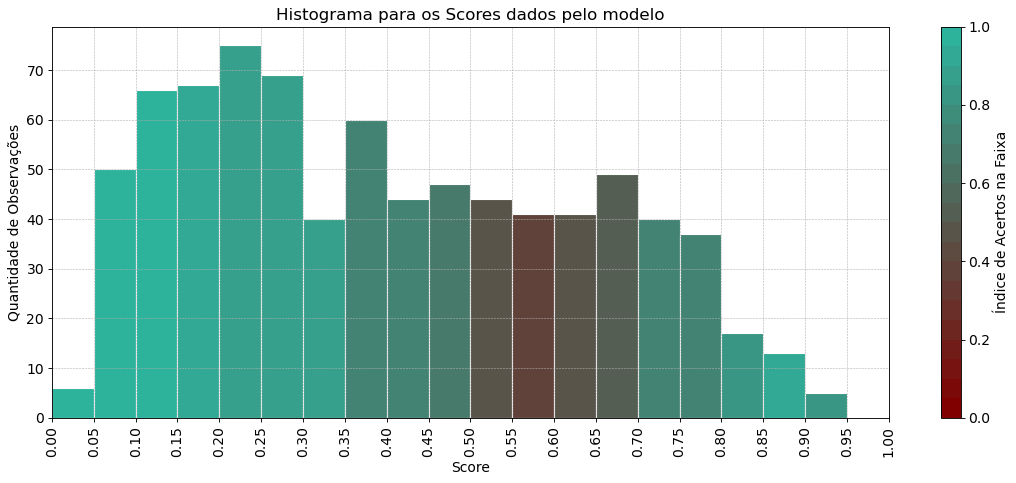

In [34]:
matplotlib.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(14, 6), dpi=80)
color='#45B39D'
scalarMappable = ScalarMappable(cmap=newcmp)
plt.bar(df_barplot['left'], df_barplot['Contagem'], width=0.05, color=scalarMappable.cmap(df_barplot['Acertos (%)']), alpha=1, linewidth=1, edgecolor='white')
colorbar = plt.colorbar(scalarMappable)
colorbar.set_label('Índice de Acertos na Faixa')
plt.xlim(0,1)
plt.grid(which='both',linestyle='--', linewidth=0.5)
plt.title('Histograma para os Scores dados pelo modelo')
plt.xlabel('Score')
plt.ylabel('Quantidade de Observações')
plt.tight_layout()
plt.xticks(ticks=np.arange(0,1.05, 0.05), rotation=90)
# plt.savefig('./docs/tcc/fig_00430_pos_prob_dados_estr.png')
plt.show()